# 2/24/21 - This notebook applies LightAndMassProfiles and dark matter profiles to the G250289_2730.
## This is the second model attempt because the first was not ideal redshift relation.
https://github.com/Jammy2211/autolens_workspace/blob/release/notebooks/imaging/modeling/light_parametric__mass_light_dark__source_parametric.ipynb

In [1]:
### libraries
%matplotlib inline
# set workspace path
from pyprojroot import here
workspace_path = str(here())#'/data/sknabel/autolens_workspace'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import matplotlib.pyplot as plt
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.stats import sigma_clip as clip
from os import path
import time

# set datetime variable
datetime = time.strftime("%d%m%Y-%H%M%S")

# paths
autoz_path = '/data/sknabel/autoz_lens_model/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
png_path = f'{autoz_path}visuals/png/'
pdf_path = f'{autoz_path}visuals/pdf/'

In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_tes

/data/sknabel/autoz_lens_model
Working Directory has been set to `/data/sknabel/autoz_lens_model`


INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Lens and source redshifts at [0.40121394] and [0.71961558].
Einstein radius prior: 0.7818634676165951
Plotting r-band


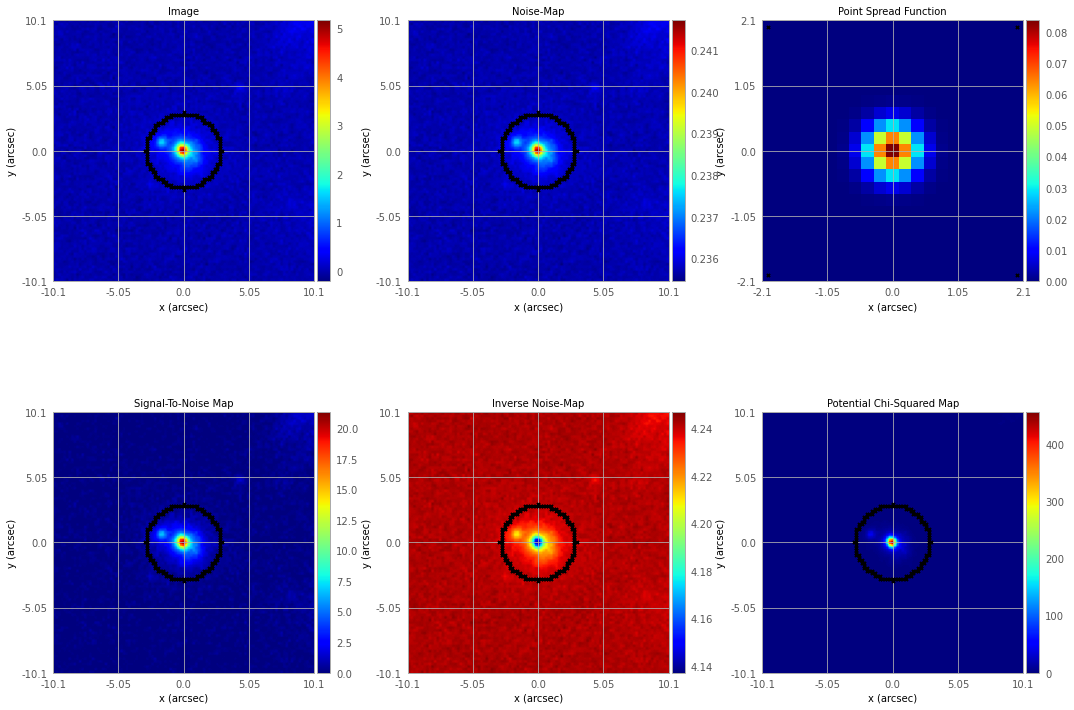

In [2]:
# this should be constant across experiments

gama_id = 250289
links_id = 2730

object_folder = f'{fits_path}G{gama_id}_{links_id}/'
output_folder = f'{autoz_path}output/G{gama_id}_{links_id}/'

# load object data table
links = pd.read_csv(f'{csv_path}/latest/links_sample_latest.csv')
lens_galaxy_data = links[links.GAMA_ID == gama_id]
zlens=lens_galaxy_data.zlens.values
zsource=lens_galaxy_data.zsource.values
einstein_radius=np.mean([lens_galaxy_data.theta_e_pm.values, lens_galaxy_data.theta_e_sis.values]) # take average of einstein radius estimates for prior
print(f'Lens and source redshifts at {zlens} and {zsource}.')
print(f'Einstein radius prior: {einstein_radius}')

# load r-band imaging
imaging_r = al.Imaging.from_fits(image_path=path.join(object_folder, f'{links_id}_r_image.fits'),
                              noise_map_path=path.join(object_folder, f'{links_id}_r_noisemap.fits'),
                              psf_path=path.join(object_folder, f'{links_id}_r_psf.fits'),
                               pixel_scales=0.2)

# set up mask
mask = al.Mask2D.circular(
    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=3.0
)
visuals_2d = aplt.Visuals2D(mask=mask)

# plot subplots for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_r.subplot_imaging()

# load g-band imaging
# no g on this one

# set up grid and settings
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D)#, psf_shape_2d=imaging.psf.shape_2d)
settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

#set up lens light profile
lens_start = al.GalaxyModel(
    redshift=zlens, bulge=al.lp.EllipticalSersic#, mass=al.mp.EllipticalIsothermal
)

# set priors
# lens position
lens_start.bulge.centre_0 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
lens_start.bulge.centre_1 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
# effective radius
#lens_start.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0) # why have I chosen 3 here? because the mask is 3...

In [12]:
# set up tools for tracking the experiments (log of outputs and table of time to convergence and log likelihood)

#Start a log.txt file
log = open(f"{autoz_path}output/G250289_2730/experiment_log", 'a')
log.write(f'This logs the outputs from autolens experiments on G250289_2730 on datetime {datetime}. PARTY ON WAYNE! \n')
log.write(f'\n')
log.close()


Empty DataFrame
Columns: [Experiment, phase1_time, phase1_likelihood, phase2_time, phase2_likelihood]
Index: []


In [4]:
# Start a pandas dataframe
#performance_log = pd.DataFrame(columns=['Experiment', 
#                                        'phase1_time', 
#                                        'phase1_likelihood', 
#                                        'phase2_time', 
#                                        'phase2_likelihood' 
#                                        ])

# load performance log from csv
performance_log = pd.read_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(performance_log)
print(performance_log)

   Unnamed: 0                      Experiment  phase1_time  phase1_likelihood  \
0           0  1-2_position2_effective_radius    61.385485         213.437572   

   phase2_time  phase2_likelihood  phase3_time  phase3_likelihood  
0  2628.087118         264.264239          0.0                0.0  


## Experiment 1: Dark matter - positions

positions_threshold = 2, 1.5, 1.0, 0.5

## 1-1 : positions_threshold = 2

In [13]:
# set experiment number
experiment_number = '1-1_positions'

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f"{object_folder}", name=f"experiment_{experiment_number}_r_fit_{datetime}", n_live_points=40,
        evidence_tolerance=1
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

In [14]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

Phase running...


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Dynesty samples found, beginning new non-linear search. 
159it [00:07, 23.05it/s, bound: 5 | nc: 5 | ncall: 1497 | eff(%): 10.621 | loglstar:   -inf < -1210.318 <    inf | logz: -1218.626 +/- 12.226 | dlogz: 1271.422 >  1.000] /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
170it [00:07, 23.45it/s, bound: 7 | nc: 14 | ncall: 1582 | eff(%): 10.746 | loglstar:   -inf < -1062.031 <    inf | logz: -1070.611 +/- 12.227 | dlogz: 1152.830 >  1.000]/soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
22

Work complete! Took us 55.87545897811651 seconds or 0.9312576496352752 minutes.


Log likelihood: 213.1774959931515


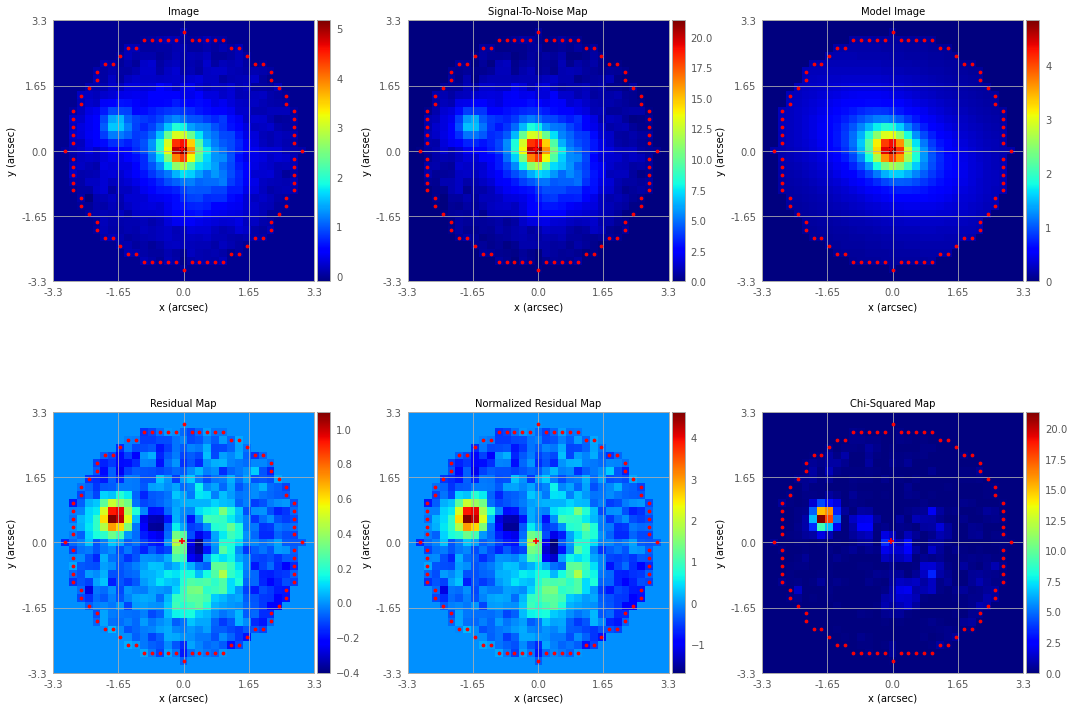

In [36]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

In [9]:
# now phase 2!

#set up lens and source

# set stellar mass/light profile
bulge = af.PriorModel(al.lmp.EllipticalSersic)
bulge.take_attributes(source=phase1_result.model.galaxies.lens.bulge)

# set dark matter profile
dark = af.PriorModel(al.mp.SphericalNFWMCRLudlow)
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = zlens
dark.redshift_source = zsource

lens = al.GalaxyModel(
    redshift=zlens, bulge=bulge, dark=dark
)

source = al.GalaxyModel(
    redshift=zsource, bulge=al.lp.SphericalExponential)

# make lens intensity default to 0.1 +- 0.1 because red to green makes it wonky
lens.bulge.intensity = af.GaussianPrior(mean=0.1, sigma=0.1)

# set uniform m_l ratio
#lens.bulge.mass_to_light_ratio = af.UniformPrior(lower_limit=0.0, upper_limit=100000.0) # leave it default

# make dark matter centered at stellar mass center
lens.dark.centre = lens.bulge.centre

# einstein radius
#lens.mass.einstein_radius = af.GaussianPrior(mean=einstein_radius, sigma=0.3*einstein_radius) # take sigma to be 30% of mean # hmmm

# source position
source.bulge.centre_0 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.centre_1 = af.UniformPrior(lower_limit=-3, upper_limit=3)
#source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0)

Plotting r-band


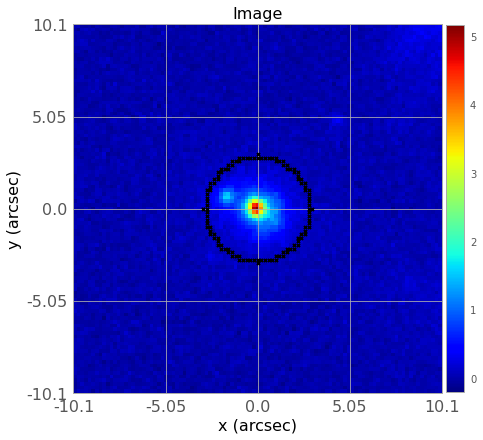

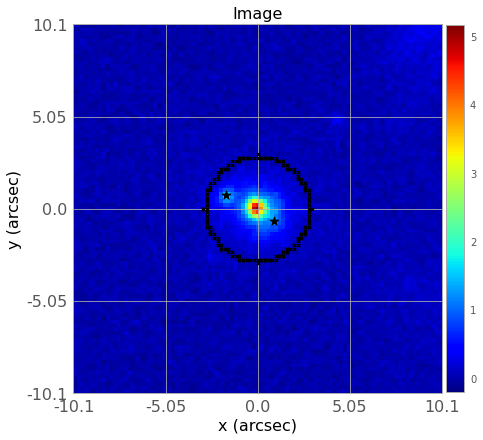

In [10]:
# Set up the positions... (GUI is not working...)

# plot the r-band image to see it
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_r.figures(image=True)

# set positions
imaging_r.positions = al.Grid2DIrregular(
    [(0.75, -1.75), (-0.7, 0.9)]
)

# plot the image
visuals_2d = aplt.Visuals2D(mask=mask, positions=imaging_r.positions)
imaging_plotter_r = aplt.ImagingPlotter(imaging=imaging_r, visuals_2d=visuals_2d)
imaging_plotter_r.figures(image=True)

In [11]:
# set the settings to include the positions
settings_lens = al.SettingsLens(positions_threshold=2.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

In [12]:
# set up phase
phase2 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f'{output_folder}', name=f"experiment_{experiment_number}_phase2_fit_{datetime}", n_live_points=120,
        evidence_tolerance=0.5, walks=10, facc=0.4
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [41]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase2_result = phase2.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
233it [01:30,  2.58it/s, +120 | bound: 14 | nc: 1 | ncall: 2628 | eff(%): 13.432 | loglstar:   -inf < 182.003 <    inf | logz: 174.581 +/-  1.050 | dlogz:  1.099 >  0.500]   
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
463it [02:02,  3.78it/s, +120 | bound: 28 | nc: 1 | ncall: 5135 | eff(%): 11.353 | loglstar:   -inf < 184.266 <    inf | logz: 175.124 +/-  0.718 | dlogz:  0.977 >  0.500] 
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
700it [02:13,  5.23it/s, +120 | bound: 41 | nc: 1 | ncall: 7637 | eff(%): 10.737 | loglstar:   -inf < 205.728 <    inf | logz: 194.822 +/-  0.919 | dlogz:  0.855 >  0.500]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
941it [02:18,  6.78it/s, +120 | bound: 55 | nc: 1 | ncall: 10140 | eff(%): 10.464 | loglstar:   -inf < 207.000 <    inf | logz: 194.601 +/-  1.147

Work complete! Took us 1219.9850275926292 seconds or 20.333083793210488 minutes.


In [42]:
# write the results to the log
print(f'Log likelihood: {phase2_result.log_likelihood}')

phase2_time=tock-tick

log = open(f"{autoz_path}output/G3575500/dark_experiment_log_G3575500", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'r-band \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'g-band \n',
         f'Time to convergence: {phase2_time} seconds \n', 
         f'Log likelihood: {phase2_result.log_likelihood} \n', 
         f'Model: {str(phase2_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

Log likelihood: 212.75893483929002


      Experiment  phase1_time  phase1_likelihood  phase2_time  \
0  1-1_positions -1305.372895         213.177496  1219.985028   

   phase2_likelihood  phase3_time  phase3_likelihood  
0         212.758935          0.0                0.0  


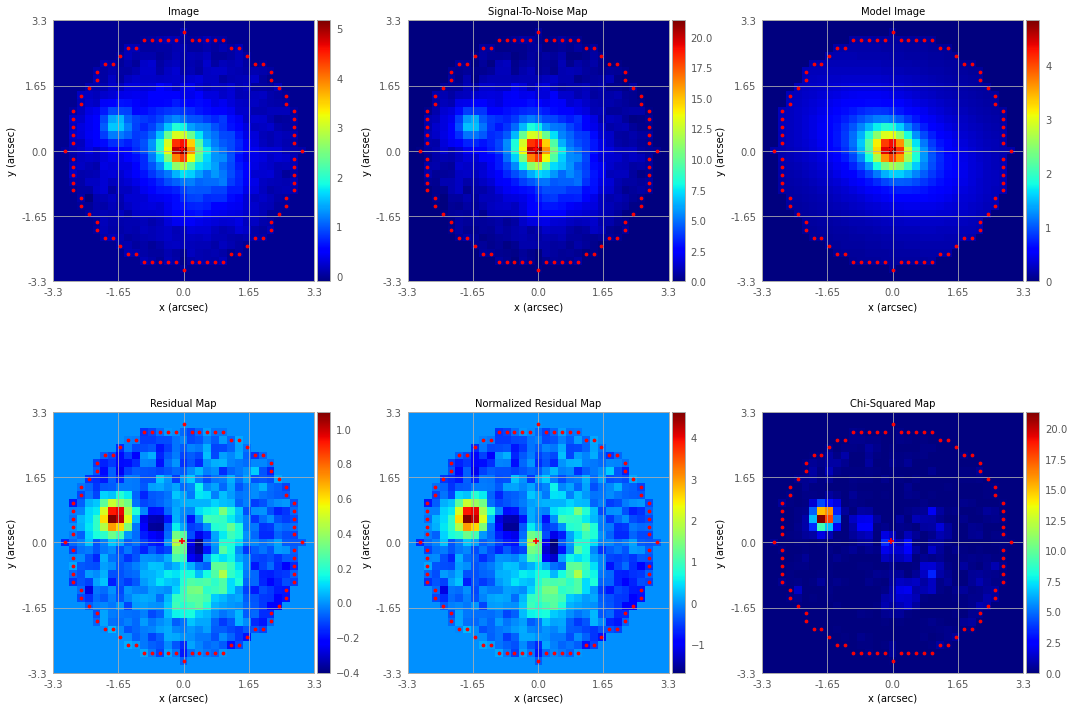

In [43]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            phase2_time, 
            phase2_result.log_likelihood,
              0, 0
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           'phase3_time',
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G3575500_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

## 1-2 : Positions threshold = 2, use effective radius from GAMA DR3 Sersic Photometry catalog. I think the last model fit the lensed light as part of the lens, which made the half-light radius larger and the ellipticity different... Not to mention including lensed light in the lens galaxy.

In [3]:
# set experiment number
experiment_number = '1-2_position2_effective_radius'

lens_start.bulge.effective_radius = af.GaussianPrior(mean=1.3435, sigma=3, lower_limit=0.0)

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f"{object_folder}", name=f"experiment_{experiment_number}_r_fit_{datetime}", n_live_points=40,
        evidence_tolerance=1
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

In [4]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

Phase running...


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Dynesty samples found, beginning new non-linear search. 
162it [00:07, 21.55it/s, bound: 4 | nc: 10 | ncall: 1538 | eff(%): 10.533 | loglstar:   -inf < -779.536 <    inf | logz: -787.748 +/-  0.721 | dlogz: 869.866 >  1.000]   /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
165it [00:07, 16.18it/s, bound: 6 | nc: 5 | ncall: 1587 | eff(%): 10.397 | loglstar:   -inf < -682.359 <    inf | logz: -690.815 +/-  0.742 | dlogz: 799.132 >  1.000] /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
205it

Work complete! Took us 61.38548481464386 seconds or 1.0230914135773976 minutes.


Log likelihood: 213.4375722584725
Model: Galaxy (centre_0, GaussianPrior, mean = 0.041974053567401755, sigma = 0.05), (centre_1, GaussianPrior, mean = -0.049734734377731515, sigma = 0.05), (elliptical_comps_0, GaussianPrior, mean = -0.17902981262586967, sigma = 0.2), (elliptical_comps_1, GaussianPrior, mean = 0.13567800230029808, sigma = 0.2), (intensity, GaussianPrior, mean = 0.08604079550005904, sigma = 0.08933123551012263), (effective_radius, GaussianPrior, mean = 4.101597702568002, sigma = 4.101597702568002), (sersic_index, GaussianPrior, mean = 4.353709028688704, sigma = 1.5), None, None


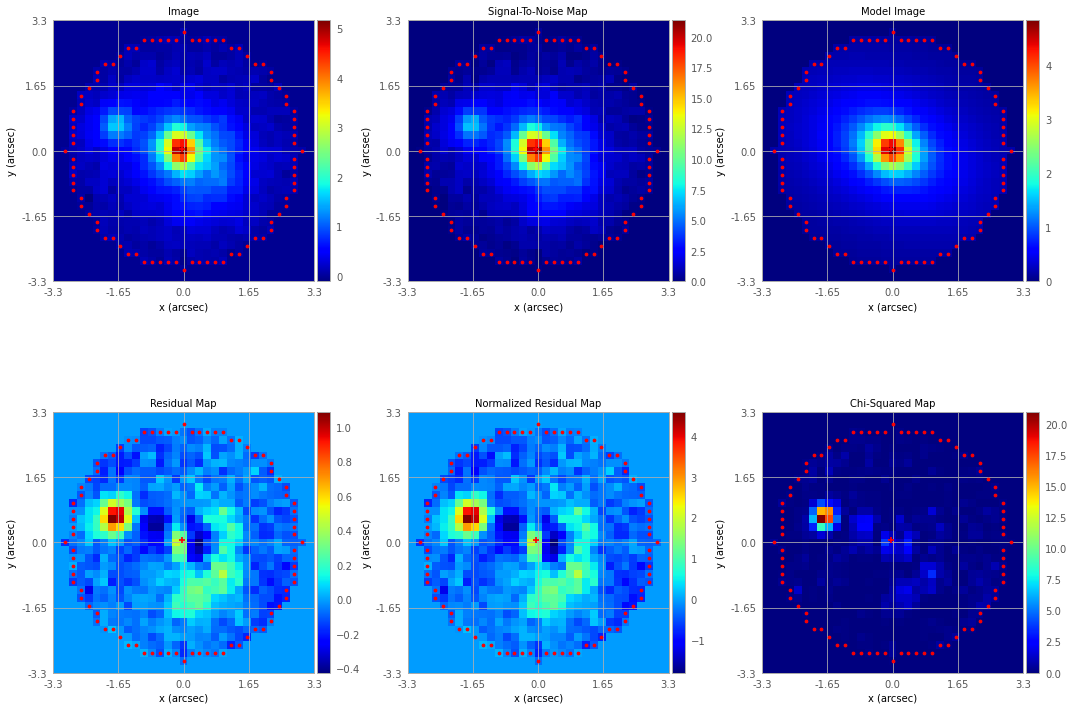

In [8]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')
print(f'Model: {phase1_result.model}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()
# it fit it basically the same way. R_E = 4.1 arcsec

In [37]:
# now phase 2!

#set up lens and source

# set stellar mass/light profile
bulge = af.PriorModel(al.lmp.EllipticalSersic)
bulge.take_attributes(source=phase1_result.model.galaxies.lens.bulge)

# set dark matter profile
dark = af.PriorModel(al.mp.SphericalNFWMCRLudlow)
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = zlens
dark.redshift_source = zsource

lens = al.GalaxyModel(
    redshift=zlens, bulge=bulge, dark=dark
)

source = al.GalaxyModel(
    redshift=zsource, bulge=al.lp.SphericalExponential)

# make lens intensity default to 0.1 +- 0.1 because red to green makes it wonky
lens.bulge.intensity = af.GaussianPrior(mean=0.1, sigma=0.1)

# set uniform m_l ratio
#lens.bulge.mass_to_light_ratio = af.UniformPrior(lower_limit=0.0, upper_limit=100000.0) # leave it default

# make dark matter centered at stellar mass center
lens.dark.centre = lens.bulge.centre

# einstein radius
#lens.mass.einstein_radius = af.GaussianPrior(mean=einstein_radius, sigma=0.3*einstein_radius) # take sigma to be 30% of mean # hmmm

# source position
source.bulge.centre_0 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.centre_1 = af.UniformPrior(lower_limit=-3, upper_limit=3)
#source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0)

Plotting r-band


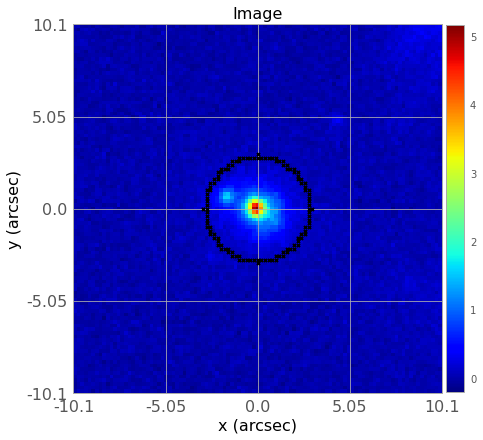

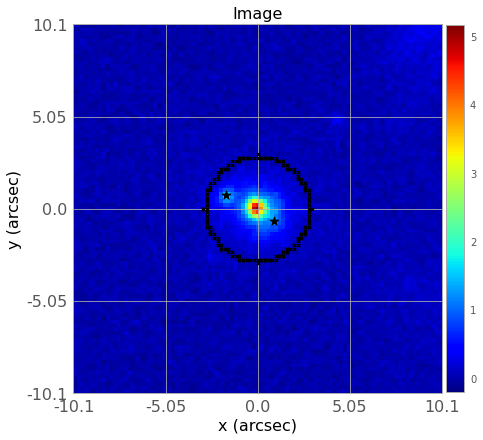

In [38]:
# Set up the positions... (GUI is not working...)

# plot the r-band image to see it
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_r.figures(image=True)

# set positions
imaging_r.positions = al.Grid2DIrregular(
    [(0.75, -1.75), (-0.7, 0.9)]
)

# plot the image
visuals_2d = aplt.Visuals2D(mask=mask, positions=imaging_r.positions)
imaging_plotter_r = aplt.ImagingPlotter(imaging=imaging_r, visuals_2d=visuals_2d)
imaging_plotter_r.figures(image=True)

In [39]:
# set the settings to include the positions
settings_lens = al.SettingsLens(positions_threshold=2.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

In [40]:
# set up phase
phase2 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f'{output_folder}', name=f"experiment_{experiment_number}_phase2_fit_{datetime}", n_live_points=120,
        evidence_tolerance=0.5, walks=10, facc=0.4
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [13]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase2_result = phase2.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
239it [01:55,  2.08it/s, +120 | bound: 14 | nc: 1 | ncall: 2628 | eff(%): 13.661 | loglstar:   -inf < 186.984 <    inf | logz: 179.512 +/-  0.841 | dlogz:  1.099 >  0.500]   
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
481it [01:56,  4.12it/s, +120 | bound: 28 | nc: 1 | ncall: 5136 | eff(%): 11.702 | loglstar:   -inf < 204.854 <    inf | logz: 195.379 +/-  1.028 | dlogz:  1.095 >  0.500]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
726it [02:12,  5.49it/s, +120 | bound: 41 | nc: 1 | ncall: 7646 | eff(%): 11.065 | loglstar:   -inf < 211.122 <    inf | logz: 199.614 +/-  1.625 | dlogz:  1.095 >  0.500]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
970it [02:18,  7.02it/s, +120 | bound: 55 | nc: 1 | ncall: 10154 | eff(%): 10.735 | loglstar:   -inf < 212.037 <    inf | logz: 199.295 +/-  1.131 

Work complete! Took us 2628.087117847055 seconds or 43.80145196411759 minutes.


In [14]:
# write the results to the log
print(f'Log likelihood: {phase2_result.log_likelihood}')

phase2_time=tock-tick

log = open(f"{autoz_path}output/G3575500/dark_experiment_log_G3575500", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'r-band \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'g-band \n',
         f'Time to convergence: {phase2_time} seconds \n', 
         f'Log likelihood: {phase2_result.log_likelihood} \n', 
         f'Model: {str(phase2_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

Log likelihood: 264.2642391513357


                       Experiment  phase1_time  phase1_likelihood  \
0  1-2_position2_effective_radius    61.385485         213.437572   

   phase2_time  phase2_likelihood  phase3_time  phase3_likelihood  
0  2628.087118         264.264239          0.0                0.0  


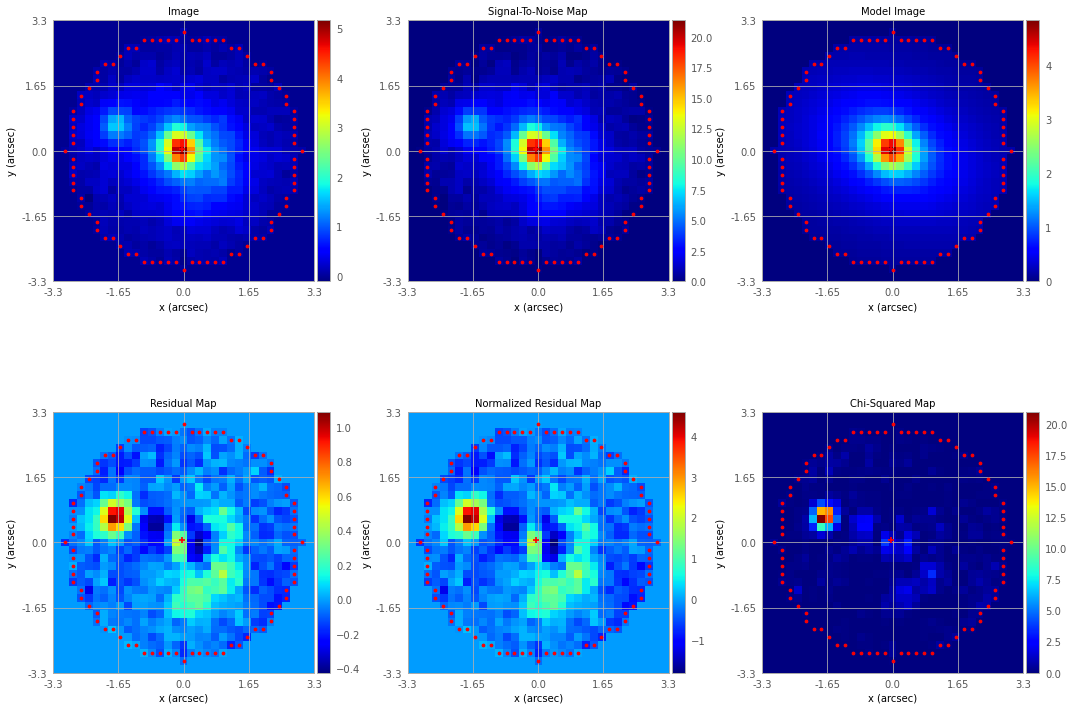

In [17]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            phase2_time, 
            phase2_result.log_likelihood,
              0, 0
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           'phase3_time',
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase2_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

## 1-3 : Positions threshold = 2, use effective radius from GAMA DR3 Sersic Photometry catalog with smaller sigma.

In [5]:
# set experiment number
experiment_number = '1-3_position2_RE_GAMA_sigma1'

lens_start.bulge.effective_radius = af.GaussianPrior(mean=1.3435, sigma=1, lower_limit=0.0)

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f"{object_folder}", name=f"experiment_{experiment_number}_r_fit_{datetime}", n_live_points=40,
        evidence_tolerance=1
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

In [6]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

Phase running...


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Dynesty samples found, beginning new non-linear search. 
184it [00:08, 24.17it/s, bound: 5 | nc: 5 | ncall: 1765 | eff(%): 10.425 | loglstar:   -inf < -538.167 <    inf | logz: -547.087 +/-    nan | dlogz: 574.724 >  1.000]    /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
280it [00:13, 21.22it/s, +40 | bound: 29 | nc: 1 | ncall: 2551 | eff(%): 12.544 | loglstar:   -inf < 152.149 <    inf | logz: 140.828 +/-    nan | dlogz:  1.099 >  1.000]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
556it [00:12, 43.33it/s, +40 | bound: 96 | nc: 1 | ncall: 5052 | eff(%): 11.797 | loglstar:   -inf < 204.518 <    inf | logz: 186.792 +/-    nan | dlogz:  

Work complete! Took us 72.79833252355456 seconds or 1.2133055420592427 minutes.


Log likelihood: 214.11751705871336
Model: Galaxy (centre_0, GaussianPrior, mean = 0.04689911462182465, sigma = 0.05), (centre_1, GaussianPrior, mean = -0.050268599612716736, sigma = 0.05), (elliptical_comps_0, GaussianPrior, mean = -0.1821229703536498, sigma = 0.2), (elliptical_comps_1, GaussianPrior, mean = 0.13711645851300594, sigma = 0.2), (intensity, GaussianPrior, mean = 0.14084170460319792, sigma = 0.08496287395899454), (effective_radius, GaussianPrior, mean = 3.0067079786855224, sigma = 3.0067079786855224), (sersic_index, GaussianPrior, mean = 3.7106208107718204, sigma = 1.5), None, None


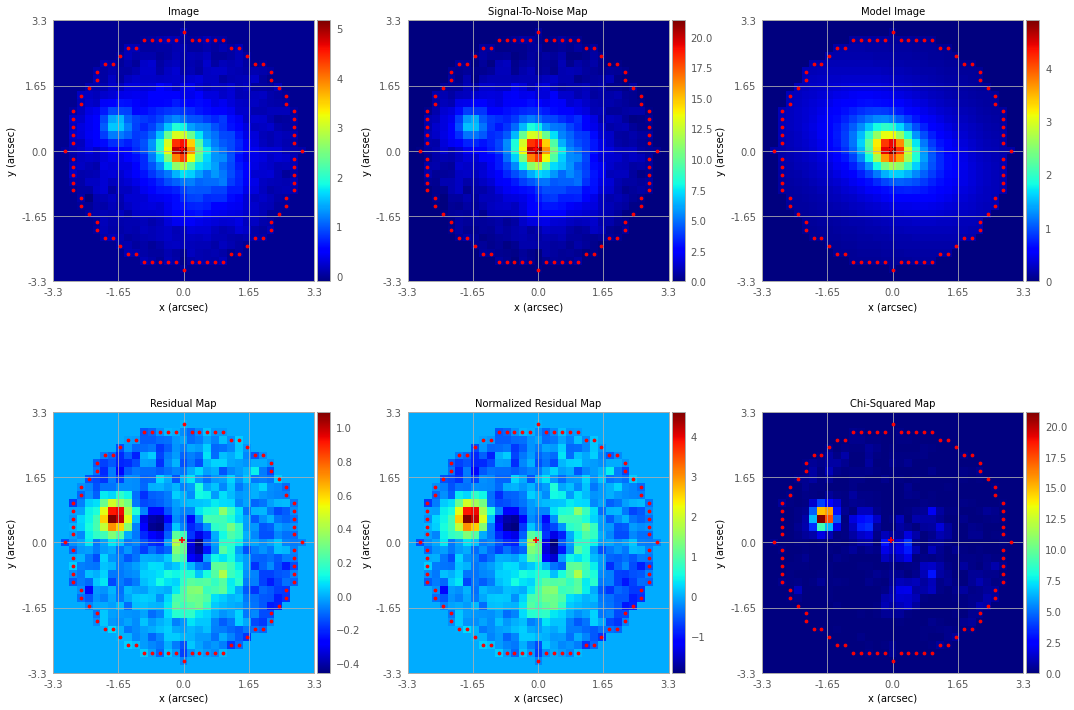

In [7]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')
print(f'Model: {phase1_result.model}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()
# it's still fitting too much of the arc light

### Just keep refining the first phase until we get a good fit.

In [9]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')

phase1_time=tock-tick

log = open(f"{autoz_path}output/G250289_2730/experiment_log", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'r-band \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'g-band \n']#,
         #f'Time to convergence: {phase2_time} seconds \n', 
         #f'Log likelihood: {phase2_result.log_likelihood} \n', 
         #f'Model: {str(phase2_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

Log likelihood: 214.11751705871336


   Unnamed: 0                      Experiment  phase1_time  phase1_likelihood  \
0         0.0  1-2_position2_effective_radius    61.385485         213.437572   
0         NaN    1-3_position2_RE_GAMA_sigma1    72.798333         214.117517   

   phase2_time  phase2_likelihood  phase3_time  phase3_likelihood  
0  2628.087118         264.264239          0.0                0.0  
0     0.000000           0.000000          0.0                0.0  


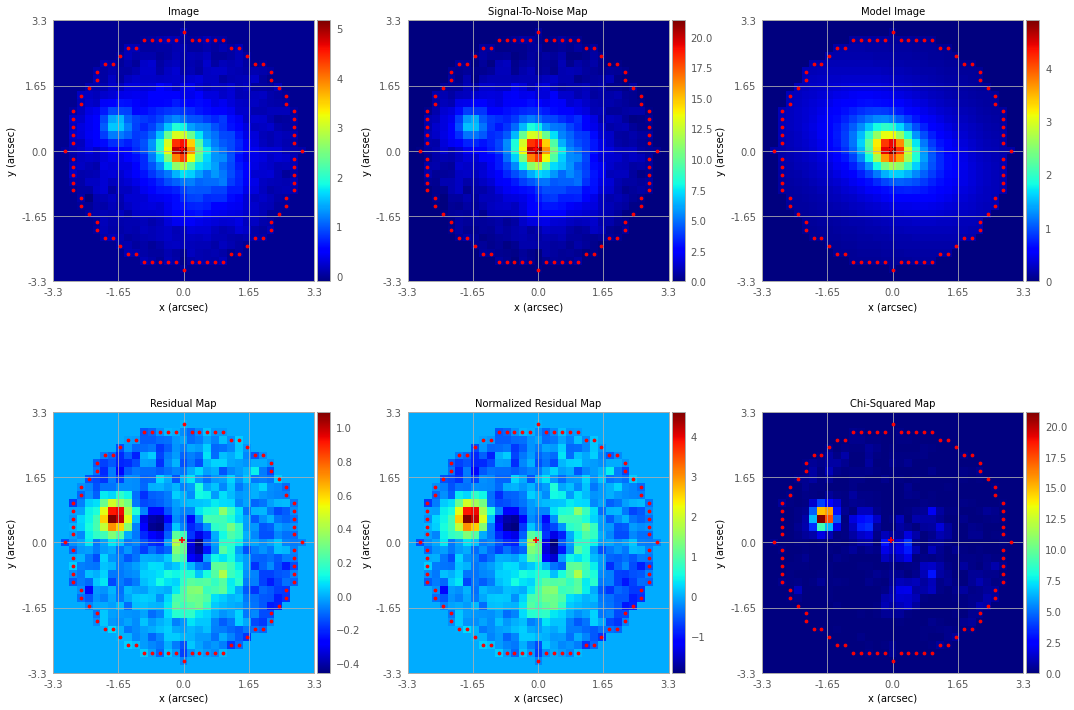

In [10]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            #phase2_time, 
            #phase2_result.log_likelihood,
             0, 0, 0, 0
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           'phase3_time',
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

## 1-4 : Positions threshold = 2, use effective radius from GAMA DR3 Sersic Photometry catalog with smaller sigma, smaller mask (1.5).

Plotting r-band


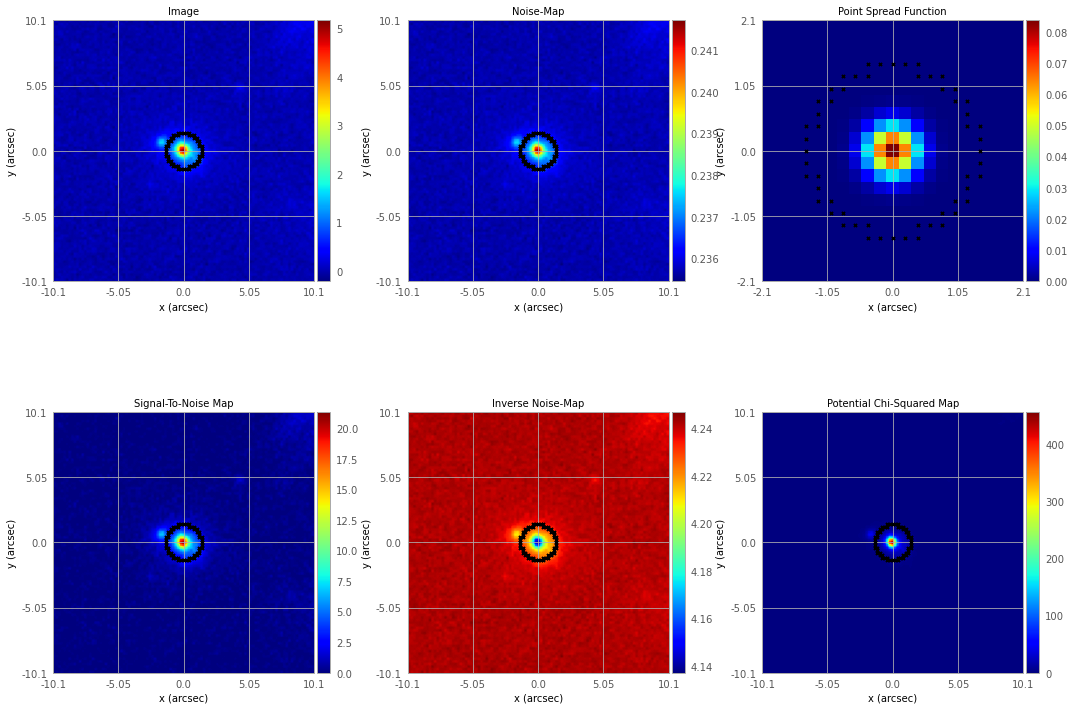

In [28]:
# set experiment number
experiment_number = '1-4_position2_RE_GAMA_sigma1_mask1pt5'

lens_start.bulge.effective_radius = af.GaussianPrior(mean=1.3435, sigma=1, lower_limit=0.0)

# set up mask
lens_mask = al.Mask2D.circular(
    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=1.5
)
visuals_2d = aplt.Visuals2D(mask=lens_mask)

# plot subplots for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=lens_mask)
)
imaging_plotter_r.subplot_imaging()

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f"{output_folder}", name=f"experiment_{experiment_number}_r_fit_{datetime}", n_live_points=40,
        evidence_tolerance=1
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

In [29]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=lens_mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
194it [00:08, 28.22it/s, bound: 8 | nc: 5 | ncall: 1830 | eff(%): 10.601 | loglstar:   -inf < -359.179 <    inf | logz: -368.283 +/-  0.660 | dlogz: 284.344 >  1.000]       /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
278it [00:12, 23.15it/s, +40 | bound: 28 | nc: 1 | ncall: 2541 | eff(%): 12.515 | loglstar:   -inf < -10.807 <    inf | logz: -22.078 +/-  1.225 | dlogz:  1.099 >  1.000]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
544it [00:11, 46.29it/s, +40 | bound: 93 | nc: 1 | ncall: 5045 | eff(%): 11.576 | loglstar:   -inf < 30.864 <    inf | logz: 14.941 +/-  1.008 | dlogz:  0.258 >  1.000]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).

Work complete! Took us 64.13643652945757 seconds or 1.0689406088242928 minutes.


Log likelihood: 41.232623854483165
Model: Galaxy (centre_0, GaussianPrior, mean = 0.03589325540036206, sigma = 0.05), (centre_1, GaussianPrior, mean = -0.04445090012853961, sigma = 0.05), (elliptical_comps_0, GaussianPrior, mean = -0.14380277955362505, sigma = 0.2), (elliptical_comps_1, GaussianPrior, mean = 0.06872106890779071, sigma = 0.2), (intensity, GaussianPrior, mean = 0.12061415335250504, sigma = 0.0822522999779675), (effective_radius, GaussianPrior, mean = 3.26706669927697, sigma = 3.26706669927697), (sersic_index, GaussianPrior, mean = 4.000864971914037, sigma = 1.5), None, None


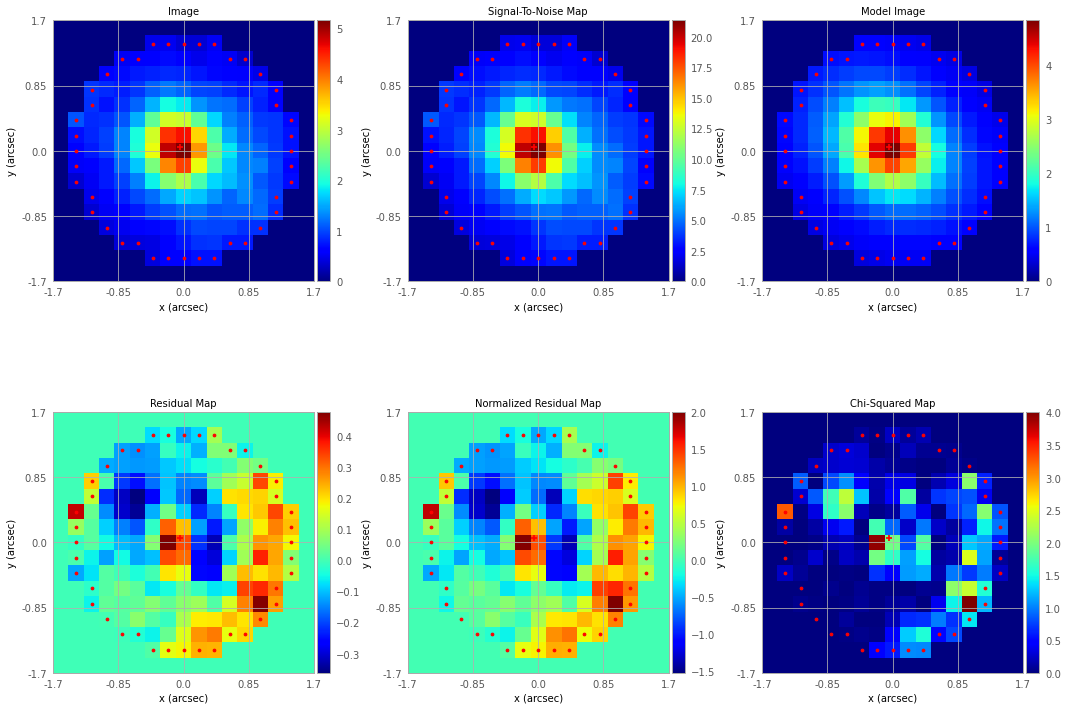

In [30]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')
print(f'Model: {phase1_result.model}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()
# it's still fitting too much of the arc light

### Just keep refining the first phase until we get a good fit.

In [31]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')

phase1_time=tock-tick

log = open(f"{autoz_path}output/G250289_2730/experiment_log", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'r-band \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'g-band \n']#,
         #f'Time to convergence: {phase2_time} seconds \n', 
         #f'Log likelihood: {phase2_result.log_likelihood} \n', 
         #f'Model: {str(phase2_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

Log likelihood: 41.232623854483165


   Unnamed: 0                             Experiment  phase1_time  \
0         0.0         1-2_position2_effective_radius    61.385485   
0         NaN           1-3_position2_RE_GAMA_sigma1    72.798333   
0         NaN  1-4_position2_RE_GAMA_sigma1_mask1pt5    72.692799   
0         NaN  1-5_position2_RE_GAMA_sigma1_mask1pt0    70.813617   
0         NaN  1-4_position2_RE_GAMA_sigma1_mask1pt5    64.136437   

   phase1_likelihood  phase2_time  phase2_likelihood  phase3_time  \
0         213.437572  2628.087118         264.264239          0.0   
0         214.117517     0.000000           0.000000          0.0   
0         216.319977     0.000000           0.000000          0.0   
0         214.652386     0.000000           0.000000          0.0   
0          41.232624     0.000000           0.000000          0.0   

   phase3_likelihood  
0                0.0  
0                0.0  
0                0.0  
0                0.0  
0                0.0  


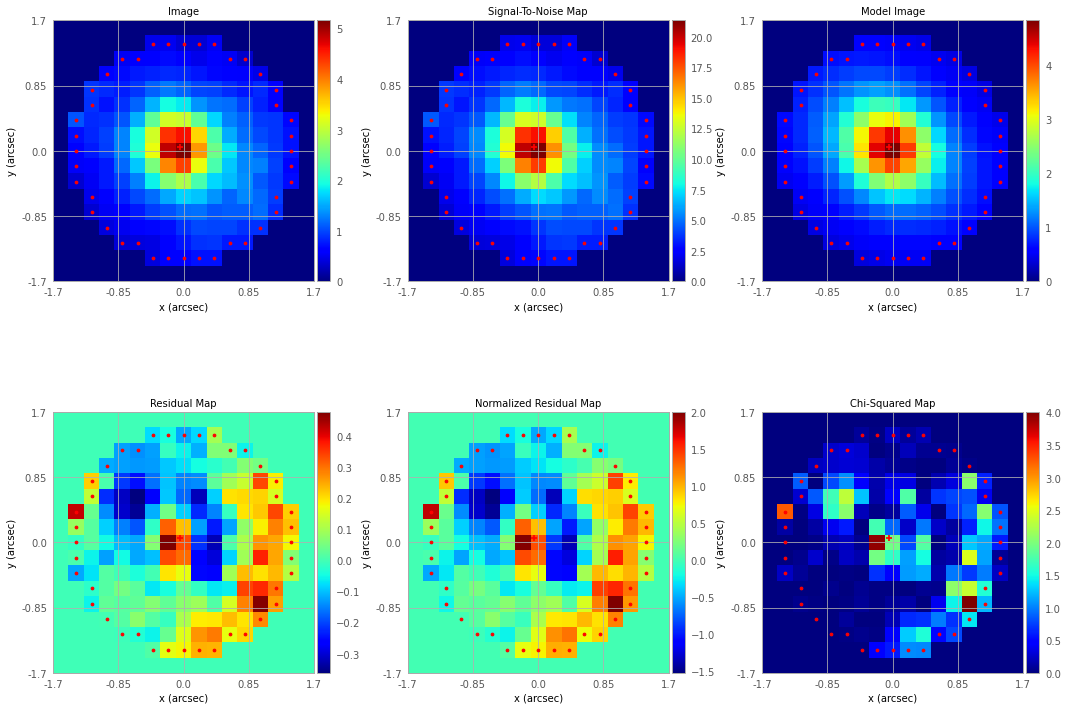

In [32]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            #phase2_time, 
            #phase2_result.log_likelihood,
             0, 0, 0, 0
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           'phase3_time',
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

## 1-5 : Positions threshold = 2, use effective radius from GAMA DR3 Sersic Photometry catalog with smaller sigma, smaller mask (1.2).

Plotting r-band


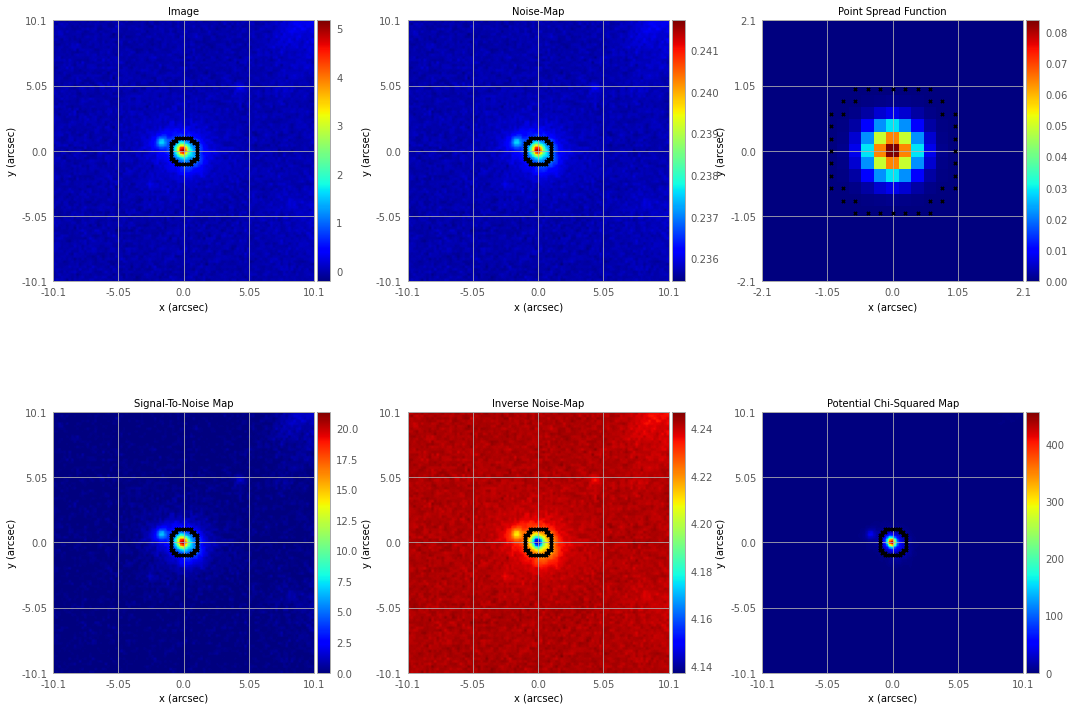

In [33]:
# set experiment number
experiment_number = '1-5_position2_RE_GAMA_sigma1_mask1pt2'

lens_start.bulge.effective_radius = af.GaussianPrior(mean=1.3435, sigma=1, lower_limit=0.0)

# set up mask
lens_mask = al.Mask2D.circular(
    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=1.2
)
visuals_2d = aplt.Visuals2D(mask=lens_mask)

# plot subplots for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=lens_mask)
)
imaging_plotter_r.subplot_imaging()

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f"{output_folder}", name=f"experiment_{experiment_number}_r_fit_{datetime}", n_live_points=40,
        evidence_tolerance=1
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

In [34]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=lens_mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
210it [00:08, 27.11it/s, bound: 17 | nc: 8 | ncall: 1843 | eff(%): 11.394 | loglstar:   -inf < -210.743 <    inf | logz: -220.093 +/-  0.663 | dlogz: 200.824 >  1.000]   /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
231it [00:09, 28.53it/s, bound: 21 | nc: 5 | ncall: 1982 | eff(%): 11.655 | loglstar:   -inf < -142.742 <    inf | logz: -152.228 +/-  0.659 | dlogz: 138.007 >  1.000]/soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
298it [00:11, 24.98it/s, +40 | bound: 36 | nc: 1 | ncall: 2541 | eff(%): 13.302 | loglstar:   -inf < -9.726 <

Work complete! Took us 49.861724212765694 seconds or 0.8310287368794282 minutes.


Log likelihood: 24.586925468325642
Model: Galaxy (centre_0, GaussianPrior, mean = 0.029876979306669903, sigma = 0.05), (centre_1, GaussianPrior, mean = -0.045841563518464724, sigma = 0.05), (elliptical_comps_0, GaussianPrior, mean = -0.11230509431503924, sigma = 0.2), (elliptical_comps_1, GaussianPrior, mean = 0.052542598133438534, sigma = 0.2), (intensity, GaussianPrior, mean = 0.14407555559031895, sigma = 0.21208673423648186), (effective_radius, GaussianPrior, mean = 2.7243357051994956, sigma = 2.7243357051994956), (sersic_index, GaussianPrior, mean = 4.149199913856564, sigma = 1.5), None, None


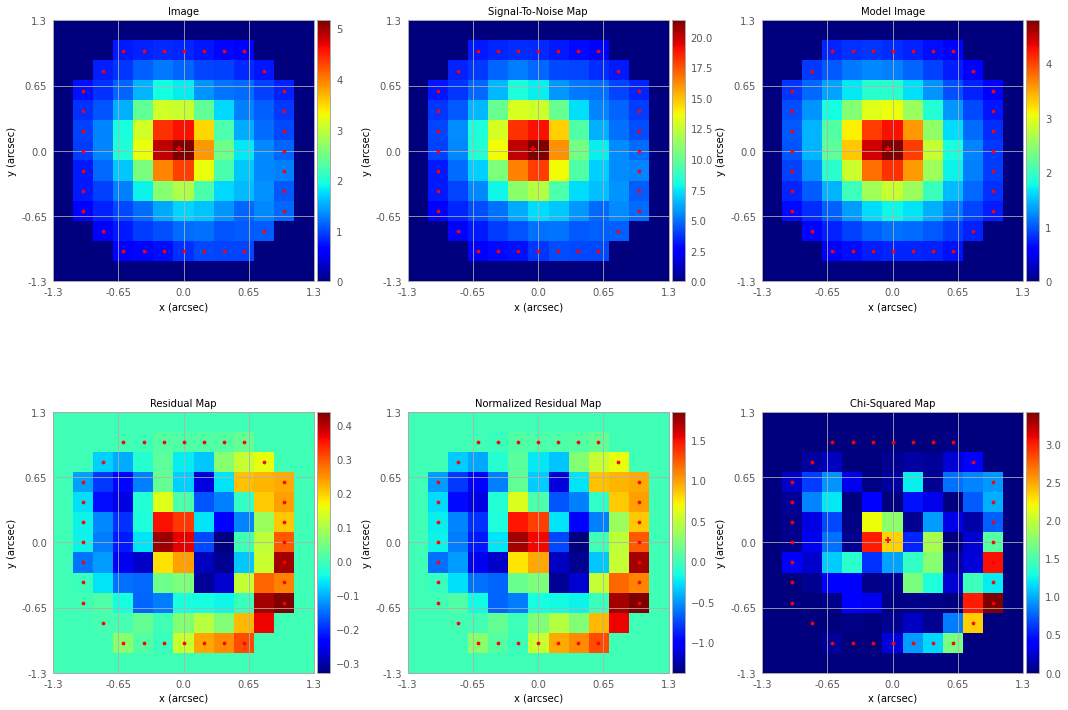

In [36]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')
print(f'Model: {phase1_result.model}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()
# it's still fitting too much of the arc light

### Just keep refining the first phase until we get a good fit.

In [37]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')

phase1_time=tock-tick

log = open(f"{autoz_path}output/G250289_2730/experiment_log", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'r-band \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'g-band \n']#,
         #f'Time to convergence: {phase2_time} seconds \n', 
         #f'Log likelihood: {phase2_result.log_likelihood} \n', 
         #f'Model: {str(phase2_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

Log likelihood: 24.586925468325642


   Unnamed: 0                             Experiment  phase1_time  \
0         0.0         1-2_position2_effective_radius    61.385485   
0         NaN           1-3_position2_RE_GAMA_sigma1    72.798333   
0         NaN  1-4_position2_RE_GAMA_sigma1_mask1pt5    72.692799   
0         NaN  1-5_position2_RE_GAMA_sigma1_mask1pt0    70.813617   
0         NaN  1-4_position2_RE_GAMA_sigma1_mask1pt5    64.136437   
0         NaN  1-5_position2_RE_GAMA_sigma1_mask1pt2    49.861724   

   phase1_likelihood  phase2_time  phase2_likelihood  phase3_time  \
0         213.437572  2628.087118         264.264239          0.0   
0         214.117517     0.000000           0.000000          0.0   
0         216.319977     0.000000           0.000000          0.0   
0         214.652386     0.000000           0.000000          0.0   
0          41.232624     0.000000           0.000000          0.0   
0          24.586925     0.000000           0.000000          0.0   

   phase3_likelihood  
0        

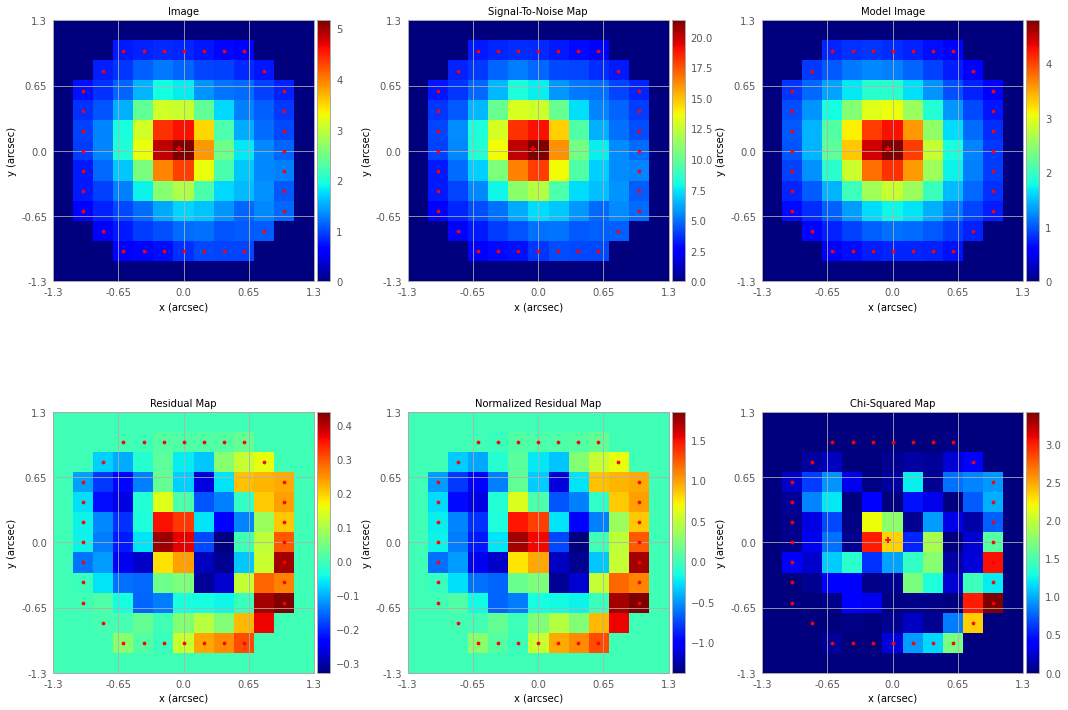

In [38]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            #phase2_time, 
            #phase2_result.log_likelihood,
             0, 0, 0, 0
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           'phase3_time',
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

## 1-6 : Positions threshold = 2, use effective radius from GAMA DR3 Sersic Photometry catalog with smaller sigma (0.5) and upper limit (2.0), smaller mask (1.0) centered at (0.046, -0.049)

Plotting r-band


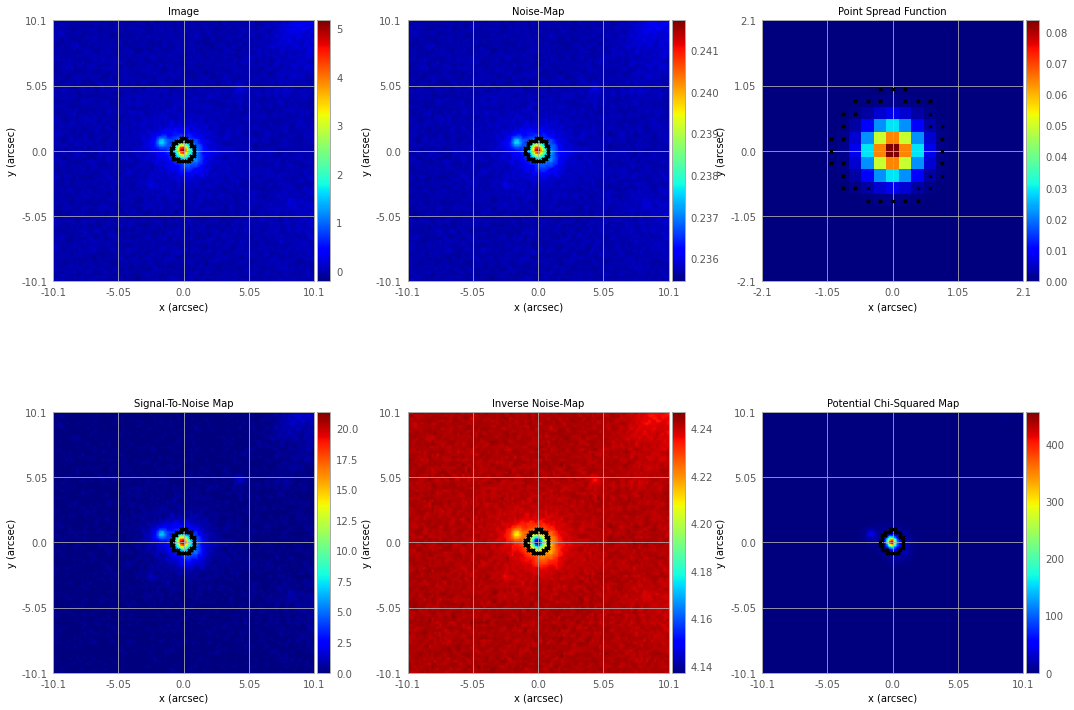

In [39]:
# set experiment number
experiment_number = '1-6_position2_RE_GAMA_sigma0pt5_mask1pt0'

lens_start.bulge.effective_radius = af.GaussianPrior(mean=1.3435, sigma=0.5, lower_limit=0.0, upper_limit=2.0)

# set up mask
lens_mask = al.Mask2D.circular(
    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=1.0, centre=(0.046, -0.049)
)
visuals_2d = aplt.Visuals2D(mask=lens_mask)

# plot subplots for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=visuals_2d
)
imaging_plotter_r.subplot_imaging()

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f"{output_folder}", name=f"experiment_{experiment_number}_r_fit_{datetime}", n_live_points=40,
        evidence_tolerance=1
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

In [40]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=lens_mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
169it [00:07, 14.77it/s, bound: 3 | nc: 5 | ncall: 1671 | eff(%): 10.114 | loglstar:   -inf < -287.203 <    inf | logz: -295.758 +/-  0.668 | dlogz: 232.073 >  1.000]   /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
179it [00:07, 21.00it/s, bound: 6 | nc: 5 | ncall: 1746 | eff(%): 10.252 | loglstar:   -inf < -223.228 <    inf | logz: -231.887 +/-  0.656 | dlogz: 162.168 >  1.000] /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
212it [00:08, 26.97it/s, bound: 12 | nc: 15 | ncall: 1965 | eff(%): 10.789 | loglstar:   -inf < -141.235 <    

Work complete! Took us 49.01633097603917 seconds or 0.8169388496006529 minutes.


Log likelihood: 23.816726499486983
Model: Galaxy (centre_0, GaussianPrior, mean = 0.03084513912736748, sigma = 0.05), (centre_1, GaussianPrior, mean = -0.052359311310825676, sigma = 0.05), (elliptical_comps_0, GaussianPrior, mean = -0.08352960247772874, sigma = 0.2), (elliptical_comps_1, GaussianPrior, mean = 0.02501842794739921, sigma = 0.2), (intensity, GaussianPrior, mean = 0.2642773529456744, sigma = 0.32204885270626177), (effective_radius, GaussianPrior, mean = 1.7386529176243615, sigma = 1.7386529176243615), (sersic_index, GaussianPrior, mean = 3.7174602852721788, sigma = 1.5), None, None


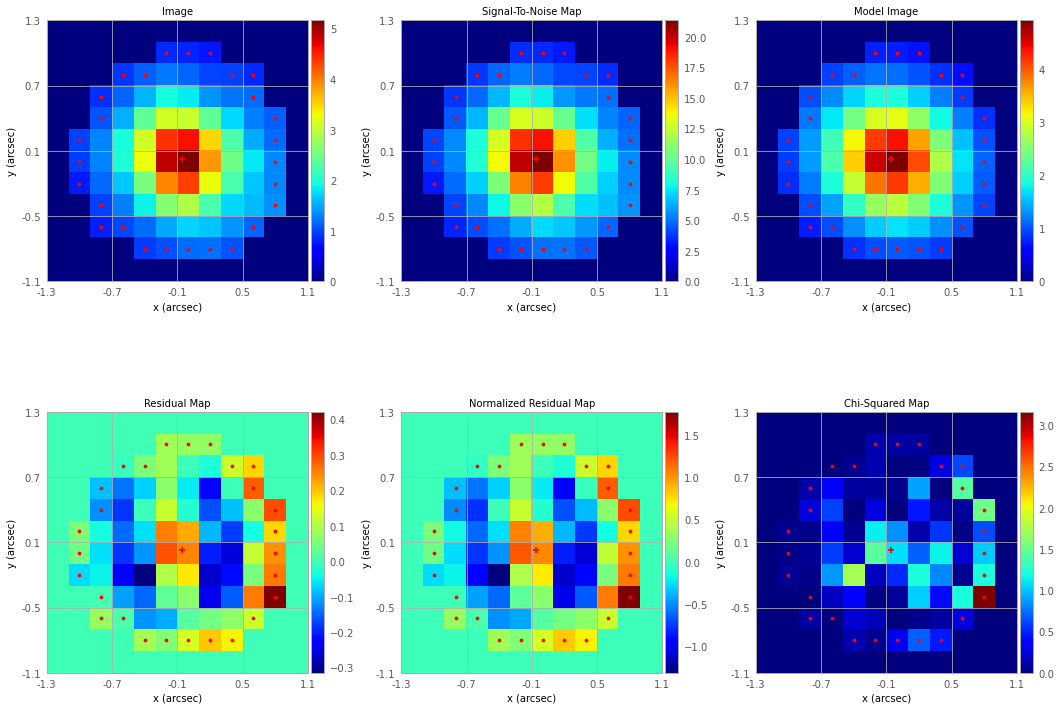

In [41]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')
print(f'Model: {phase1_result.model}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()
# it's still fitting too much of the arc light

### This looks better.

In [43]:
# now phase 2!

#set up lens and source

# set stellar mass/light profile
bulge = af.PriorModel(al.lmp.EllipticalSersic)
bulge.take_attributes(source=phase1_result.model.galaxies.lens.bulge)

# set dark matter profile
dark = af.PriorModel(al.mp.SphericalNFWMCRLudlow)
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = zlens
dark.redshift_source = zsource

lens = al.GalaxyModel(
    redshift=zlens, bulge=bulge, dark=dark
)

source = al.GalaxyModel(
    redshift=zsource, bulge=al.lp.SphericalExponential)

# make lens intensity default to 0.1 +- 0.1 because red to green makes it wonky
#lens.bulge.intensity = af.GaussianPrior(mean=0.1, sigma=0.1)

# set uniform m_l ratio
#lens.bulge.mass_to_light_ratio = af.UniformPrior(lower_limit=0.0, upper_limit=100000.0) # leave it default

# make dark matter centered at stellar mass center
lens.dark.centre = lens.bulge.centre

# einstein radius
#lens.mass.einstein_radius = af.GaussianPrior(mean=einstein_radius, sigma=0.3*einstein_radius) # take sigma to be 30% of mean # hmmm

# source position
source.bulge.centre_0 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.centre_1 = af.UniformPrior(lower_limit=-3, upper_limit=3)
#source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0)

Plotting r-band


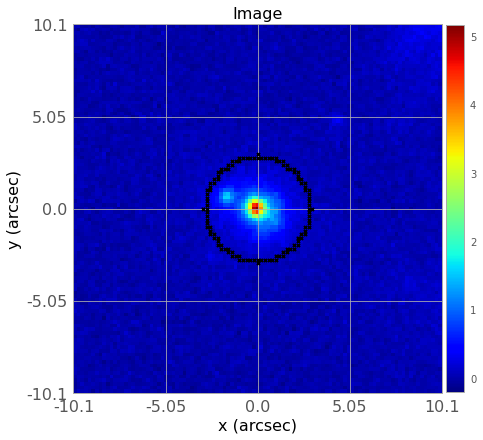

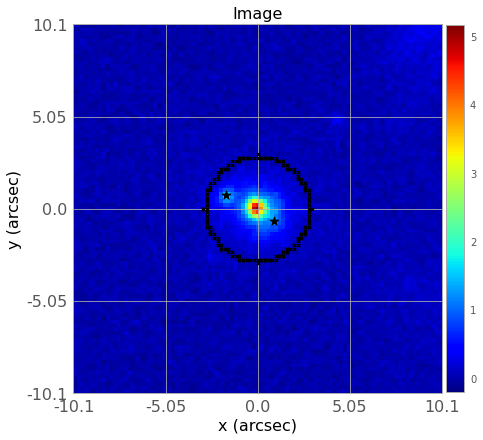

In [44]:
# Set up the positions... (GUI is not working...)

# plot the r-band image to see it
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_r.figures(image=True)

# set positions
imaging_r.positions = al.Grid2DIrregular(
    [(0.75, -1.75), (-0.7, 0.9)]
)

# plot the image
visuals_2d = aplt.Visuals2D(mask=mask, positions=imaging_r.positions)
imaging_plotter_r = aplt.ImagingPlotter(imaging=imaging_r, visuals_2d=visuals_2d)
imaging_plotter_r.figures(image=True)

In [45]:
# set the settings to include the positions
settings_lens = al.SettingsLens(positions_threshold=2.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

In [46]:
# set up phase
phase2 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f'{output_folder}', name=f"experiment_{experiment_number}_phase2_fit_{datetime}", n_live_points=120,
        evidence_tolerance=0.5, walks=10, facc=0.4
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [47]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase2_result = phase2.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
247it [01:37,  2.54it/s, +120 | bound: 14 | nc: 1 | ncall: 2622 | eff(%): 13.997 | loglstar:   -inf < 158.463 <    inf | logz: 150.956 +/-  0.613 | dlogz:  1.077 >  0.500]   
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
488it [02:02,  3.98it/s, +120 | bound: 27 | nc: 1 | ncall: 5127 | eff(%): 11.859 | loglstar:   -inf < 186.824 <    inf | logz: 178.224 +/-    nan | dlogz:  0.578 >  0.500]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
730it [02:32,  4.79it/s, +120 | bound: 41 | nc: 1 | ncall: 7634 | eff(%): 11.134 | loglstar:   -inf < 192.168 <    inf | logz: 181.084 +/-  0.839 | dlogz:  0.815 >  0.500]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
973it [02:14,  7.23it/s, +120 | bound: 55 | nc: 1 | ncall: 10140 | eff(%): 10.779 | loglstar:   -inf < 204.736 <    inf | logz: 191.570 +/-  1.158 

KeyboardInterrupt: 

In [ ]:
# write the results to the log
print(f'Log likelihood: {phase2_result.log_likelihood}')

phase2_time=tock-tick

log = open(f"{autoz_path}output/G3575500/dark_experiment_log_G3575500", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'r-band \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'g-band \n',
         f'Time to convergence: {phase2_time} seconds \n', 
         f'Log likelihood: {phase2_result.log_likelihood} \n', 
         f'Model: {str(phase2_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

In [ ]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            phase2_time, 
            phase2_result.log_likelihood,
              0, 0
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           'phase3_time',
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase2_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

In [ ]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            #phase2_time, 
            #phase2_result.log_likelihood,
             0, 0, 0, 0
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           'phase3_time',
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()